### Import libraries

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import umap

/home/arka/SCAI/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data (Task 1)

In [2]:
files = glob.glob("ECG_data/**/*.csv", recursive=True)

In [3]:
heart_rate_files = [x for x in files if "hr" in x]
respiration_files = [x for x in files if "rr" in x]
ecg_files = [x for x in files if "ecg" in x]

### Extract the data (Task 2)

##### Heart Rate, Respiration Rate have similar structure

In [4]:
heart_rate_file = heart_rate_files[0]
respiration_file = respiration_files[0]
ecg_file = ecg_files[0]
acceleration = respiration_files[1] ## Assuming this is acceleration data

In [5]:
def get_file(file, name):
    df = pd.read_csv(file)
    df["time"] = pd.to_datetime(df["date"], dayfirst=True)  + pd.to_timedelta(df["minute"], unit='m')
    df.set_index("time", inplace=True)
    df.drop(columns=["date", "minute"], inplace=True)
    df.rename(columns={"value": name}, inplace=True)
    return df

In [6]:
hr = get_file(heart_rate_file, "hr")

In [7]:
rr = get_file(respiration_file, "rr")

In [8]:
acc = get_file(acceleration, "acc")

##### ECG data is processed differently

In [9]:
ecg = pd.read_csv(ecg_file)

In [10]:
ecg

,Second,ECG value in uV
0,665.793000,-0.004
1,665.800812,-0.005
2,665.808625,0.001
3,665.816437,0.027
4,665.824250,0.025
...,...,...
375574,3599.964875,-0.024
375575,3599.972687,-0.023
375576,3599.980500,-0.020
375577,3599.988312,-0.022


In [11]:
ecg["time"] = pd.to_datetime("22.02.2022", dayfirst=True)  + pd.to_timedelta(ecg["Second"], unit='s')

In [12]:
ecg.rename(columns={"ECG value in uV": "ECG"}, inplace=True)

In [13]:
# How should one combine the ecg data so that we can have a minute by minute data frame?

In [14]:
ecg["Second"].diff().value_counts()

Second
0.007812    375574
0.007813         2
0.007812         1
0.007813         1
Name: count, dtype: int64

In [15]:
sampling_interval = ecg["Second"].diff().value_counts().idxmax()

In [16]:
sampling_rate = 1/sampling_interval

In [17]:
sampling_rate

np.float64(128.0)

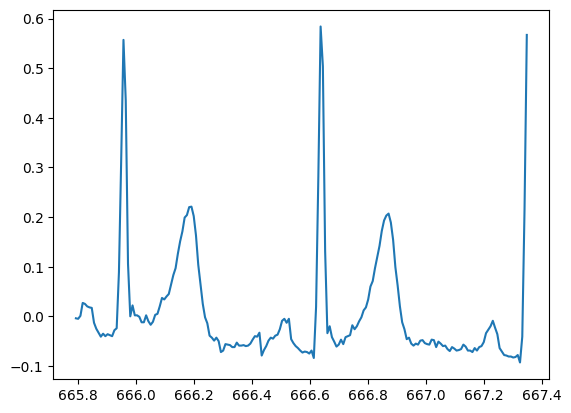

In [18]:
plt.plot(ecg["Second"][:200], ecg["ECG"][:200])

In [19]:
_, rpeaks = nk.ecg_peaks(ecg["ECG"], sampling_rate=sampling_rate)

In [20]:
ecg_signals, ecg_info = nk.ecg_process(ecg["ECG"], sampling_rate=sampling_rate)

In [21]:
r_peaks = np.array(ecg_info["ECG_R_Peaks"])
p_peaks = np.array(ecg_info["ECG_P_Peaks"])
t_peaks = np.array(ecg_info["ECG_T_Peaks"])
q_peaks = np.array(ecg_info["ECG_Q_Peaks"])
s_peaks = np.array(ecg_info["ECG_S_Peaks"])

In [22]:
pr_intervals = (q_peaks - p_peaks) / sampling_rate
qt_intervals = (t_peaks - q_peaks) / sampling_rate
qrs_intervals = (s_peaks - q_peaks) / sampling_rate

In [23]:
ecg.set_index("time", inplace=True)

In [24]:
intervals_df = pd.DataFrame({"pr": pr_intervals, "qt": qt_intervals, "qrs": qrs_intervals, "time": ecg.index[r_peaks]})

In [25]:
intervals_df

,pr,qt,qrs,time
0,0.093750,0.257812,0.085938,2022-02-22 00:11:06.636749983
1,0.078125,0.273438,0.125000,2022-02-22 00:11:07.355499983
2,0.085938,0.273438,0.125000,2022-02-22 00:11:08.105499983
3,0.046875,0.304688,0.132812,2022-02-22 00:11:08.792999983
4,0.062500,0.289062,0.132812,2022-02-22 00:11:09.488312483
...,...,...,...,...
3771,0.070312,0.328125,0.085938,2022-02-22 00:59:56.746124983
3772,0.062500,0.335938,0.093750,2022-02-22 00:59:57.574249983
3773,0.078125,0.328125,0.085938,2022-02-22 00:59:58.339874983
3774,0.078125,0.320312,0.085938,2022-02-22 00:59:59.191437483


In [26]:
intervals_df.set_index("time", inplace=True)

In [27]:
ecg_minute = intervals_df.resample("min").mean()

In [28]:
ecg_minute.describe()

,pr,qt,qrs
count,49.000000,49.000000,49.000000
mean,0.075393,0.304893,0.101878
std,0.008210,0.023240,0.010471
min,0.062610,0.263021,0.086164
25%,0.070429,0.275979,0.092252
50%,0.072667,0.314921,0.102848
75%,0.076713,0.321963,0.109630
max,0.100610,0.333065,0.123681


The date and the time over which the ECG works is not the same for the HR, RR

### Analysis of provided data (Task 3)

In [29]:
show_hrv = nk.hrv(r_peaks, sampling_rate=128, show=True)

In [ ]:
df_combined = pd.concat([hr, rr, acc], axis=1)

In [ ]:
df_combined

,hr,rr,acc
time,,,
2022-02-19 01:00:00,65.0,18.10,18.10
2022-02-19 01:01:00,65.0,18.20,18.20
2022-02-19 01:02:00,69.0,16.50,16.50
2022-02-19 01:03:00,67.0,18.25,18.25
2022-02-19 01:04:00,69.0,18.80,18.80
...,...,...,...
2022-02-21 20:52:00,78.0,21.80,21.80
2022-02-21 20:53:00,78.0,24.75,24.75
2022-02-21 20:54:00,76.0,24.60,24.60


In [ ]:
df_combined_stats = df_combined.resample("H").agg(["mean", "std", "min", "max", "median"],)

/tmp/ipykernel_105202/4276787878.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_combined_stats = df_combined.resample("H").agg(["mean", "std", "min", "max", "median"],)


In [ ]:
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

# Create a Styler object and apply colors
def color_columns(x):
    color_df = pd.DataFrame('', index=x.index, columns=x.columns)
    for i, col in enumerate(x.columns.levels[0]):
        color_df[col] = f'background-color: {colors[i % len(colors)]}'
    return color_df

# Apply the coloring
styled_df = df_combined_stats.style.apply(color_columns, axis=None)
styled_df

In [ ]:
day_time = df_combined_stats[((df_combined_stats.index.hour < 19) & (df_combined_stats.index.hour > 8))]
night_time = df_combined_stats[((df_combined_stats.index.hour >= 19) | (df_combined_stats.index.hour <= 8))]

In [ ]:

styled_df = day_time.style.apply(color_columns, axis=None)
styled_df

In [ ]:

styled_df = night_time.style.apply(color_columns, axis=None)
styled_df

##### Interesting points

There are certain points like 4PM to 6PM where the sensors do not seem to be working. In some cases for the respiration rate, the minimum value is 0 over the hour which is interesting.
There is a high correlation between the high accerlation over the hour and the heart rate. A high acceleration corresponds to a high heart rate which is expected.

#### Correlation Plots (Task 4)

<Axes: >

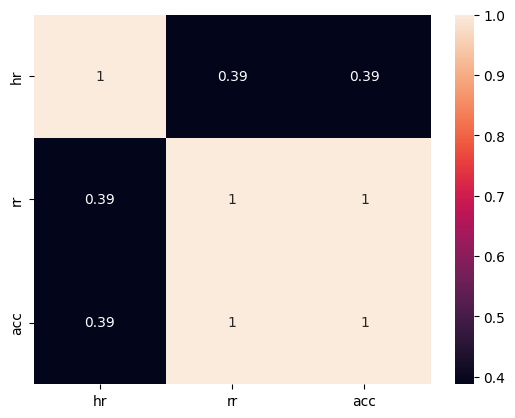

In [ ]:
sns.heatmap(df_combined[["hr","rr","acc"]].corr(), annot=True)

This is the plot over the whole time period. However, the correlation between the acceleration and respiratory rate is the same. <br>
This means that the acceleration and the respiratory sensor are almost the same. <br>
A deeper look into the data shows that the rr19to21Feb and rr19to21Feb (1) are indeed the same. <br>
From here onward, only the correlation between the rr and hr has been considered <br>

In [ ]:
df_combined["night"] = (df_combined.index.hour >= 19) | (df_combined.index.hour <= 8)
df_combined["hour_date"] = df_combined.index.strftime("%d-%m-%Y %H")

In [ ]:
## Provides the correlation between the different variables for each hour for each day
df_temp.groupby("hour_date")[["rr", "hr"]].corr()["rr"].unstack()["hr"]

hour_date
19-02-2022 01   -0.038005
19-02-2022 02   -0.160773
19-02-2022 03    0.248605
19-02-2022 04   -0.282901
19-02-2022 05   -0.332697
                   ...   
21-02-2022 16    0.486830
21-02-2022 17   -0.408559
21-02-2022 18    0.388831
21-02-2022 19    0.265742
21-02-2022 20    0.222090
Name: hr, Length: 67, dtype: float64

In [ ]:
## Provides the correlation between the different variables for each hour every day
df_combined.groupby(df_combined.index.hour)[["rr", "hr"]].corr()["rr"].unstack()["hr"]

time
0     0.226430
1     0.264251
2     0.388962
3     0.142247
4     0.548929
5     0.331015
6     0.754270
7     0.173072
8     0.564965
9     0.271980
10    0.025315
11    0.110731
12    0.293688
13    0.541727
14    0.317446
15    0.367947
16    0.665699
17    0.200160
18    0.249169
19    0.108817
20    0.445347
21    0.247346
22    0.833579
23    0.546262
Name: hr, dtype: float64

In [ ]:
df_combined.groupby("night")[["rr", "hr"]].corr()["rr"].unstack()["hr"]

night
False    0.337303
True     0.393278
Name: hr, dtype: float64

The values are more correlated at night (which has been defined from 5pm to 8am).

### Unsupervised Clustering (Task 5)

The HR and RR are only being considered. Since acc data is not present.

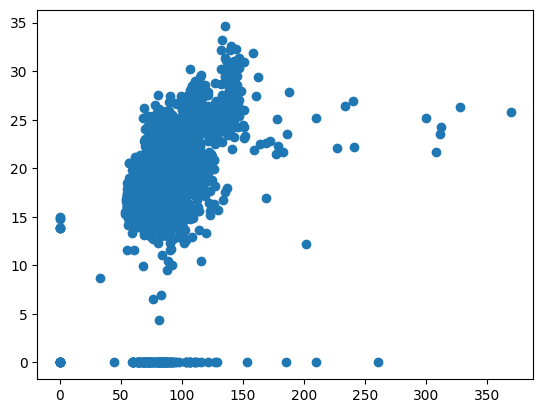

In [ ]:
plt.scatter(df_combined["hr"], df_combined["rr"])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined[["hr", "rr"]])


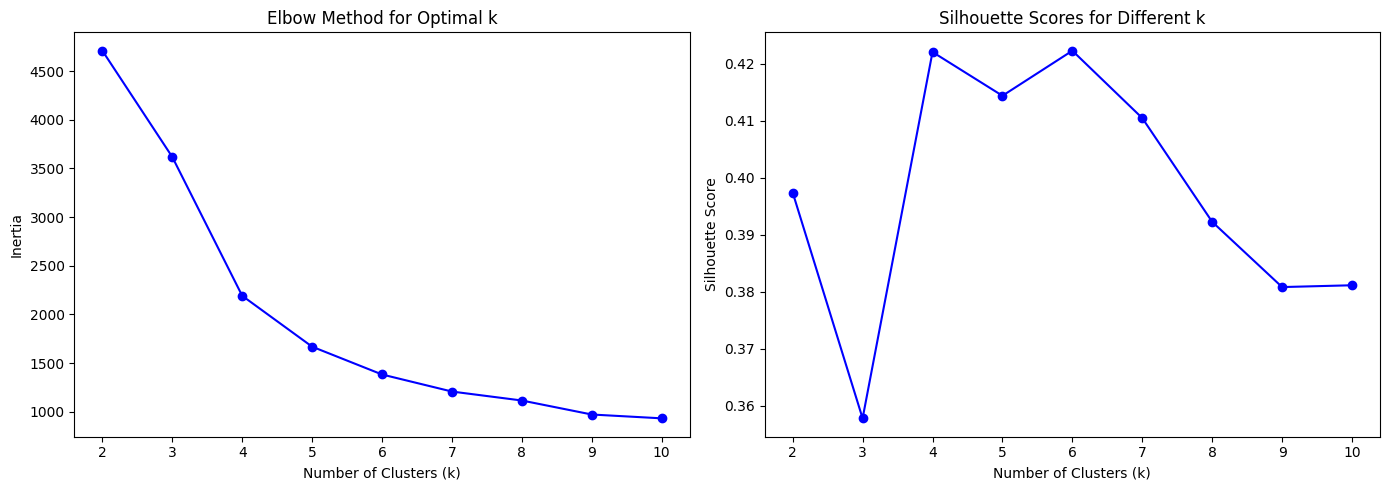

In [ ]:

k_values = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Step 4: Plot evaluation metrics
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')

plt.tight_layout()
plt.show()


Based on  the elbow method and the metrics, 4 or 6 is a good number of subsamples. <br> Based on visual inspection, 4 seems to be a better judgement.

In [ ]:
def plot_clusters(X, kmeans, ax):
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=20, alpha=0.75)
    ax.set_title(f'k = {kmeans.n_clusters}')
    ax.set_xlabel('hr scaled')
    ax.set_ylabel('rr scaled')

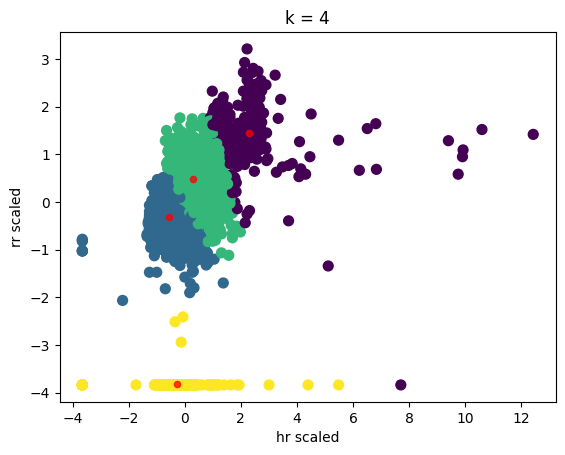

In [ ]:
ax = plt.gca()
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_scaled)
plot_clusters(X_scaled, kmeans, ax)

This shows one of the possible division of the subspace.

### Discussion Point for Code

The data only considered one person with a single device.
If multiple devices or people were considered, there could have been more interesting results:
1. Anomaly detection could have been used to figure out which user has readings which can be considered an outlier.
2. Anomaly detection could also be used to figure out which device is malfunctioning. If there are certain relations between the different devices while for another, it is not present, it is likely to be faulty.

Regarding scalability of the code
1. For the users who are present in the study, if the data time frame over which they are studied are the same and kept in same csv, there should also not be a lot of issues.
2. For different devices, the number of devices that are used can either be put into the same csv (either by having them as the same time stamps or by expanding the other data to the higher time stamp). It is kind of seen in the ECG data where the frequency of sampling was 128 Hz while for others, it is 1 per minute. For this notebook, I had converted the ECG data to be sampled 1 per minute after extraction of relevant features.
3. The code has been written in a way so that the number of days does not matter.
The code uses glob which should provide all the relevant csv files.


Hope the coding style and methods look sound.